In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots
using LaTeXStrings

# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if inside obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## Plotting functions

In [4]:
function plot_env_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter ==1 
            color = :darkblue
            plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
        elseif iter == length(X_all)
            color = :green
            plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
        else
            color = :blue
            plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
        end
        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_solution (generic function with 1 method)

In [5]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

In [6]:
function plot_three_comp_3D(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

plot_three_comp_3D (generic function with 7 methods)

In [7]:
function plot_three_comp(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_three_comp (generic function with 7 methods)

## Reading and writing to files

In [8]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [9]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end
    

getDataParamsFromHDF5Combo (generic function with 1 method)

In [10]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin_train = read(f["xMin_train"])
    yMin_train = read(f["yMin_train"])
    xRange_train = read(f["xRange_train"])
    yRange_train = read(f["yRange_train"])
    xMin_test = read(f["xMin_test"])
    yMin_test = read(f["yMin_test"])
    xRange_test = read(f["xRange_test"])
    yRange_test = read(f["yRange_test"])
    xMin_valid = read(f["xMin_valid"])
    yMin_valid = read(f["yMin_valid"])
    xRange_valid = read(f["xRange_valid"])
    yRange_valid = read(f["yRange_valid"])
    close(f)
    return (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end
    

getDataParamsFromHDF5 (generic function with 1 method)

## NN helper functions

In [11]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [12]:
function recoverXUfromCoeffsSingleDim(coeffs, dim)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    if dim<=x_dim
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_array)
        traj = this_poly
    else
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        traj = this_poly
    end
    
    return traj
end

recoverXUfromCoeffsSingleDim (generic function with 1 method)

In [13]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [14]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [15]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [16]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [17]:
function getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid)  = getDataParamsFromHDF5(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end

getNNStructure (generic function with 1 method)

In [18]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

In [19]:
function getNNPrediction(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) = getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin_train, xRange_train)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin_train, yRange_train)
    return (X_soln, U_soln)
end

getNNPrediction (generic function with 1 method)

In [20]:
function getNNCoeffsCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    return (outputCoeffs)
end

getNNCoeffsCombo (generic function with 1 method)

## Get model on which data was collected and training done

In [21]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [22]:
function getModelWithCornerSpheres()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]
    model.obstacles = []
    obstacles = []
    obs = [[0.0,0.0,0.0], 6.0]
    push!(obstacles, obs)
    obs = [[5.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[3.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[5.0,3.0,0.0], 1.3]
    push!(obstacles, obs)
    model.obstacles = obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithCornerSpheres (generic function with 1 method)

In [23]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

# Compare GuSTO to NN for all full validation set

## Compare relative error between X_NN and X_poly 

In [30]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

row = 10
meanError = zeros(size(X_valid_norm,1))
for row in 1:size(X_valid_norm,1)

    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
#         @show norm(X_soln_poly[j,:])
#             @show norm(X_soln_NN[j,:] - X_soln_poly[j,:])
#         totalerror = totalerror + norm(X_soln_NN[i,:] - X_soln_poly[i,:])/norm(X_soln_poly[i,:])
#         totalerror = totalerror + norm(X_soln_NN[j,:] - X_soln_poly[j,:])
        if norm(X_soln_poly[j,:])<1e-2 && norm(X_soln_NN[j,:] - X_soln_poly[j,:])<0.2
            totalerror = totalerror
        elseif norm(X_soln_poly[j,:])<1e-2
            @show norm(X_soln_poly[j,:])
            @show norm(X_soln_NN[j,:] - X_soln_poly[j,:])
        else
            totalerror = totalerror + norm(X_soln_NN[j,:] - X_soln_poly[j,:])/norm(X_soln_poly[j,:])
        end
    end
    @show totalerror
    for j in 1:u_dim
#         @show norm(U_soln_poly[j,:])
#             @show norm(U_soln_NN[j,:] - U_soln_poly[j,:])
        if norm(U_soln_poly[j,:])<1e-2 && norm(U_soln_NN[j,:] - U_soln_poly[j,:])<0.2
            totalerror = totalerror
        elseif norm(U_soln_poly[j,:])<1e-2
            @show norm(U_soln_poly[j,:])
            @show norm(U_soln_NN[j,:] - U_soln_poly[j,:])
        else
            totalerror = totalerror + norm(U_soln_NN[j,:] - U_soln_poly[j,:])/norm(U_soln_poly[j,:])
        end
            
    end
#     @show totalerror
#     @show totalerror/(x_dim+u_dim)
    meanError[row] = totalerror/(x_dim+u_dim)
    @show meanError[row]
    
end
#     gr = plot()
#     plot!(X_soln_poly[1,:],X_soln_poly[2,:], lab="poly")
#     plot!(X_soln_NN[1,:],X_soln_NN[2,:], lab="NN")



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
norm(X_soln_poly[j, :]) = 3.4203562988385046e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.2438900253749009
totalerror = 8.04734254541479
meanError[row] = 0.9330288559858883
row = 2
norm(X_soln_poly[j, :]) = 9.087653471269652e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3357476257285151
totalerror = 0.18877034845754342
meanError[row] = 0.030664780609444664
row = 3
norm(X_soln_poly[j, :]) = 1.338765780366286e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3374574112371424
totalerror = 0.9920084588010178
meanError[row] = 0.18881356916233413
row = 4
norm(X_soln_poly[j, :]) = 3.108466773106568e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.25219565736344735
totalerror = 3.0789358658148442
meanError[row] = 0.3566561269818365
row = 5
norm(X_soln_poly[j, :]) = 1.1428504739606236e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34082962903794956
totalerror = 0.2588894642787967
meanError[row] = 0.02739599708066166

norm(X_soln_poly[j, :]) = 0.002275414279089769
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.36022085273504106
totalerror = 0.36339444576613966
meanError[row] = 0.055304166377494746
row = 78
norm(X_soln_poly[j, :]) = 6.004380457995917e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3136612707538487
totalerror = 0.8974327660587995
meanError[row] = 0.09080491522076849
row = 79
norm(X_soln_poly[j, :]) = 9.728042662855466e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3466071009320009
totalerror = 1.1019011245223196
meanError[row] = 0.13094463955127453
row = 80
norm(X_soln_poly[j, :]) = 2.0333974201643505e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3409511216013588
totalerror = 0.27385306359051403
meanError[row] = 0.03337764528243041
row = 81
norm(X_soln_poly[j, :]) = 7.433176968894698e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3431786377042811
totalerror = 0.20976288009052774
meanError[row] = 0.0415000114769234
row = 82
norm(X_soln_poly[j, :]) = 8.582479572607812e-6
norm(X_s

norm(X_soln_poly[j, :]) = 0.00039833162265073954
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.32008970053998814
totalerror = 0.3290016854714364
meanError[row] = 0.046093270699679674
row = 159
norm(X_soln_poly[j, :]) = 8.850039966277562e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3362883454436972
totalerror = 1.103248151671576
meanError[row] = 0.18159860573805384
row = 160
totalerror = 6.291734773575199
meanError[row] = 0.3759539950896647
row = 161
norm(X_soln_poly[j, :]) = 8.637892023021152e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.349313406793817
totalerror = 2.612435286416487
meanError[row] = 0.25236092821204287
row = 162
norm(X_soln_poly[j, :]) = 1.9617668437676123e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.35587399256430025
totalerror = 0.2712164708428674
meanError[row] = 0.047321964875834774
row = 163
norm(X_soln_poly[j, :]) = 7.75210877564727e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34825952935056453
totalerror = 0.33599230960705084
meanError[row] = 0.0

norm(X_soln_poly[j, :]) = 0.0018492496384438398
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3071577297721756
totalerror = 0.6981210370705576
meanError[row] = 0.08840973974269968
row = 245
norm(X_soln_poly[j, :]) = 1.7804017322870252e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.33190255769202404
totalerror = 0.8360694901401315
meanError[row] = 0.15105958622563137
row = 246
norm(X_soln_poly[j, :]) = 5.916589940738534e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3454262826953638
totalerror = 0.36424743937460125
meanError[row] = 0.050114888973447305
row = 247
norm(X_soln_poly[j, :]) = 6.497025069004816e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3405793501977451
totalerror = 0.2966354968196277
meanError[row] = 0.051139732200187055
row = 248
norm(X_soln_poly[j, :]) = 6.373825203594747e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3434861030777863
totalerror = 0.1592505991981837
meanError[row] = 0.015673527331661587
row = 249
norm(X_soln_poly[j, :]) = 5.946757882224123e-7
n

norm(X_soln_poly[j, :]) = 1.6436760184765257e-5
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3543705459743695
totalerror = 1.6780098066543079
meanError[row] = 0.295010781396768
row = 331
norm(X_soln_poly[j, :]) = 6.560601026934087e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3525188069563367
totalerror = 1.3046644373958551
meanError[row] = 0.20459074792644824
row = 332
norm(X_soln_poly[j, :]) = 1.3708536455631022e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3436281114674264
totalerror = 0.08987546139845619
meanError[row] = 0.009065198346437727
row = 333
norm(X_soln_poly[j, :]) = 3.602283326132949e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.28010612607983293
totalerror = 2.3602660900987935
meanError[row] = 0.2796745742244618
row = 334
norm(X_soln_poly[j, :]) = 4.593584315065187e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3546165895433099
totalerror = 0.29076094437490774
meanError[row] = 0.019911943766776657
row = 335
norm(X_soln_poly[j, :]) = 5.277770262565941e-7
norm

norm(X_soln_poly[j, :]) = 1.8981466001128994e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3525853705826922
totalerror = 0.15620963646246572
meanError[row] = 0.020458137515129492
row = 374
norm(X_soln_poly[j, :]) = 2.396677551373316e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3558880267188208
totalerror = 0.8108131868774298
meanError[row] = 0.09900504206958863
row = 375
norm(X_soln_poly[j, :]) = 1.5222916668357349e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3575518109688279
totalerror = 0.2380761107098233
meanError[row] = 0.032857863595501656
row = 376
norm(X_soln_poly[j, :]) = 5.237678757683687e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.337131888412942
totalerror = 0.466210387445286
meanError[row] = 0.051048752419727485
row = 377
norm(X_soln_poly[j, :]) = 8.837309303647728e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.30065011043687817
totalerror = 24.245812065115533
meanError[row] = 1.32025856922087
row = 378
norm(X_soln_poly[j, :]) = 1.2956855899190825e-6
norm(

norm(X_soln_poly[j, :]) = 3.619097431997264e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.36616062956896755
totalerror = 0.4771630479956138
meanError[row] = 0.07121591818207153
row = 460
norm(X_soln_poly[j, :]) = 9.436594036972075e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3342114024574546
totalerror = 0.3161269152870262
meanError[row] = 0.022518016557082837
row = 461
norm(X_soln_poly[j, :]) = 1.6960513992872642e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.342986709128251
totalerror = 0.729044745826076
meanError[row] = 0.07465724179610064
row = 462
norm(X_soln_poly[j, :]) = 1.9454690083812665e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34542811745709484
totalerror = 0.27435622791693937
meanError[row] = 0.03392109660808401
row = 463
norm(X_soln_poly[j, :]) = 1.3268983967347063e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34361822921358726
totalerror = 0.2090143732212397
meanError[row] = 0.019768172037543063
row = 464
norm(X_soln_poly[j, :]) = 6.845070340550705e-8
n

norm(X_soln_poly[j, :]) = 3.095821065909945e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3124738901478861
totalerror = 1.2267639008169284
meanError[row] = 0.12296893164230598
row = 546
norm(X_soln_poly[j, :]) = 3.1570919031099687e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34522011378973244
totalerror = 0.406278739018483
meanError[row] = 0.051582296837073466
row = 547
norm(X_soln_poly[j, :]) = 0.009106881779459746
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3921452344762175
totalerror = 1.5871244055719231
meanError[row] = 0.20977281112017848
row = 548
norm(X_soln_poly[j, :]) = 6.912409558583767e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34885376066650975
totalerror = 0.5582496822678197
meanError[row] = 0.05652595661778316
row = 549
norm(X_soln_poly[j, :]) = 1.1305652233983585e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3542607015200605
totalerror = 0.5251245341617155
meanError[row] = 0.07460443135537448
row = 550
norm(X_soln_poly[j, :]) = 2.9567840259519733e-7
nor

totalerror = 7.48077174173333
meanError[row] = 0.4206418938903772
row = 632
norm(X_soln_poly[j, :]) = 9.438666552767548e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34078516040400536
totalerror = 0.6673680886698766
meanError[row] = 0.06777493611599018
row = 633
norm(X_soln_poly[j, :]) = 1.1623861107347247e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3520311505755111
totalerror = 0.16997685471783217
meanError[row] = 0.01405360903178704
row = 634
norm(X_soln_poly[j, :]) = 4.237294403320441e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3148557995599175
totalerror = 0.8930640346224475
meanError[row] = 0.12088045739126138
row = 635
norm(X_soln_poly[j, :]) = 8.18369062803727e-8
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.31762270605742965
totalerror = 0.4617458924179338
meanError[row] = 0.047553683926746394
row = 636
norm(X_soln_poly[j, :]) = 1.0778290185142797e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3515628754759247
totalerror = 0.1074600713042157
meanError[row] = 0.01

norm(X_soln_poly[j, :]) = 3.555872058405164e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34259179491665503
totalerror = 0.38379350061312134
meanError[row] = 0.04864449148813549
row = 718
totalerror = 22.303383360294905
meanError[row] = 1.234193904521256
row = 719
norm(X_soln_poly[j, :]) = 2.696956151809462e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3472477906775084
totalerror = 0.5190490163432238
meanError[row] = 0.05739734366751476
row = 720
norm(X_soln_poly[j, :]) = 7.136330410432871e-8
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.35128234414747983
totalerror = 1.7824467268553934
meanError[row] = 0.2500307210866323
row = 721
norm(X_soln_poly[j, :]) = 3.3671229040842633e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3698665829167926
totalerror = 0.32695767633081996
meanError[row] = 0.030673461957617488
row = 722
norm(X_soln_poly[j, :]) = 1.9118487934752315e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3462390977091228
totalerror = 0.09488772102596527
meanError[row] = 0

norm(X_soln_poly[j, :]) = 1.1108616085353451e-5
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.36676120795931855
totalerror = 1.8846927066720534
meanError[row] = 0.24045675764255356
row = 804
norm(X_soln_poly[j, :]) = 1.6090435839070673e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3400681399312743
totalerror = 0.9242171651008586
meanError[row] = 0.1025141371872289
row = 805
norm(X_soln_poly[j, :]) = 5.436008806239706e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3567522005998631
totalerror = 0.6910204020338301
meanError[row] = 0.06820783963207558
row = 806
norm(X_soln_poly[j, :]) = 5.228432128755728e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3735161553227613
totalerror = 1.3358073955659653
meanError[row] = 0.17198628394266152
row = 807
norm(X_soln_poly[j, :]) = 5.202155040701983e-5
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34694644661644836
totalerror = 0.8092065181973324
meanError[row] = 0.08898419718547845
row = 808
norm(X_soln_poly[j, :]) = 4.2984665014277495e-8
norm

norm(X_soln_poly[j, :]) = 0.0005970349343843082
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.27053075364990514
totalerror = 1.5166842311271518
meanError[row] = 0.1521920671121281
row = 890
norm(X_soln_poly[j, :]) = 9.197234918541417e-8
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.33032459544176074
totalerror = 2.347629091906452
meanError[row] = 0.26623542271981404
row = 891
norm(X_soln_poly[j, :]) = 1.0458839453964698e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.33742677443026436
totalerror = 0.484567076228389
meanError[row] = 0.08890217914982446
row = 892
norm(X_soln_poly[j, :]) = 3.6831038575706966e-8
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.35494801570508855
totalerror = 0.39395201146134895
meanError[row] = 0.05020932174781318
row = 893
totalerror = 22.745558778599605
meanError[row] = 1.2469746762642089
row = 894
norm(X_soln_poly[j, :]) = 2.2425430389290675e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34320971949083484
totalerror = 0.32752108864139323
meanError[row] =

norm(X_soln_poly[j, :]) = 2.541044130186514e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3368492298094497
totalerror = 1.816454915929957
meanError[row] = 0.1871589336686158
row = 976
norm(X_soln_poly[j, :]) = 4.012887441429942e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3512625296182192
totalerror = 0.19529050395264957
meanError[row] = 0.017396981498327174
row = 977
norm(X_soln_poly[j, :]) = 8.096429673043576e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34352038382496514
totalerror = 0.11950717762348058
meanError[row] = 0.014733445471704961
row = 978
totalerror = 27.82308459321096
meanError[row] = 1.5279892061236267
row = 979
norm(X_soln_poly[j, :]) = 4.789505710302266e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3260270663644355
totalerror = 0.5453367333687489
meanError[row] = 0.052930673339728666
row = 980
norm(X_soln_poly[j, :]) = 6.256776665268547e-8
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.34856138404778525
totalerror = 0.42518434637273966
meanError[row] = 0.

norm(X_soln_poly[j, :]) = 1.3838755314680033e-6
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.33449927247231453
totalerror = 0.40263511910999916
meanError[row] = 0.062141807496272516
row = 1062
norm(X_soln_poly[j, :]) = 6.016739335349397e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3546197978351403
totalerror = 0.2364179252184866
meanError[row] = 0.03702623028381136
row = 1063
norm(X_soln_poly[j, :]) = 6.165417199964367e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.35307994430550854
totalerror = 1.2805044549659939
meanError[row] = 0.14201119729332728
row = 1064
norm(X_soln_poly[j, :]) = 7.19460656116041e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.3593751734720778
totalerror = 0.5245990128501867
meanError[row] = 0.04634365480373103
row = 1065
norm(X_soln_poly[j, :]) = 8.440328026948724e-7
norm(X_soln_NN[j, :] - X_soln_poly[j, :]) = 0.35256047954623665
totalerror = 0.4039684524954165
meanError[row] = 0.03199173554478949
row = 1066
norm(X_soln_poly[j, :]) = 1.3389967226428046e

In [31]:
@show mean(meanError)
@show std(meanError)
@show maximum(meanError)
findall(x->x>5, meanError)

mean(meanError) = 0.12544715548744229
std(meanError) = 0.23688556440670094
maximum(meanError) = 2.7456592334694787


0-element Array{Int64,1}

## Compare relative error between NN coeffs and real coeffs

### Collect the true coeffs and NN coeffs

In [24]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

true_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)
NN_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)

for row in 1:size(X_valid_norm,1)
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    # NN prediction time and trajectory
    NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(NN_coeffs)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    true_coeffs = y_v_norm.*yRange + yMin
#     @show size(true_coeffs)

    for dim in 1:(x_dim+u_dim)
        true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        true_coeffs_matrix[row,dim,:] = true_cf_this
        NN_coeffs_matrix[row,dim,:] = NN_cf_this
    end
end
print("All coefficients saved to matrices")            

size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
row = 2
row = 3
row = 4
row = 5
row = 6
row = 7
row = 8
row = 9
row = 10
row = 11
row = 12
row = 13
row = 14
row = 15
row = 16
row = 17
row = 18
row = 19
row = 20
row = 21
row = 22
row = 23
row = 24
row = 25
row = 26
row = 27
row = 28
row = 29
row = 30
row = 31
row = 32
row = 33
row = 34
row = 35
row = 36
row = 37
row = 38
row = 39
row = 40
row = 41
row = 42
row = 43
row = 44
row = 45
row = 46
row = 47
row = 48
row = 49
row = 50
row = 51
row = 52
row = 53
row = 54
row = 55
row = 56
row = 57
row = 58
row = 59
row = 60
row = 61
row = 62
row = 63
row = 64
row = 65
row = 66
row = 67
row = 68
row = 69
row = 70
row = 71
row = 72
row = 73
row = 74
row = 75
row = 76
row = 77
row = 78
row = 79
row = 80
row = 81
row = 82
row = 83
row = 84
row = 85
row = 86
row = 87
row = 88
row = 89
row = 90
row = 91
row = 92
row = 93
row = 94
row = 95
row = 96
row = 97
row = 98
row = 99
row = 100
row = 101
row = 102
row = 103
row = 104
row 

row = 827
row = 828
row = 829
row = 830
row = 831
row = 832
row = 833
row = 834
row = 835
row = 836
row = 837
row = 838
row = 839
row = 840
row = 841
row = 842
row = 843
row = 844
row = 845
row = 846
row = 847
row = 848
row = 849
row = 850
row = 851
row = 852
row = 853
row = 854
row = 855
row = 856
row = 857
row = 858
row = 859
row = 860
row = 861
row = 862
row = 863
row = 864
row = 865
row = 866
row = 867
row = 868
row = 869
row = 870
row = 871
row = 872
row = 873
row = 874
row = 875
row = 876
row = 877
row = 878
row = 879
row = 880
row = 881
row = 882
row = 883
row = 884
row = 885
row = 886
row = 887
row = 888
row = 889
row = 890
row = 891
row = 892
row = 893
row = 894
row = 895
row = 896
row = 897
row = 898
row = 899
row = 900
row = 901
row = 902
row = 903
row = 904
row = 905
row = 906
row = 907
row = 908
row = 909
row = 910
row = 911
row = 912
row = 913
row = 914
row = 915
row = 916
row = 917
row = 918
row = 919
row = 920
row = 921
row = 922
row = 923
row = 924
row = 925
row = 926


## (Older) Other error measures that were blowing up

In [25]:
@show mean(true_coeffs_matrix)
@show minimum(true_coeffs_matrix)
@show maximum(true_coeffs_matrix)

@show mean(NN_coeffs_matrix)
@show minimum(NN_coeffs_matrix)
@show maximum(NN_coeffs_matrix)

mean(true_coeffs_matrix) = 0.12517492915204667
minimum(true_coeffs_matrix) = -0.0828736807972254
maximum(true_coeffs_matrix) = 10.039947061851288
mean(NN_coeffs_matrix) = 0.12464425362559085
minimum(NN_coeffs_matrix) = -0.0828736807972254
maximum(NN_coeffs_matrix) = 10.330243799369457


10.330243799369457

In [26]:
diff_coeffs = NN_coeffs_matrix - true_coeffs_matrix
@show mean(diff_coeffs)
@show minimum(diff_coeffs)
@show maximum(diff_coeffs)

rel_error_coeffs = abs.((NN_coeffs_matrix - true_coeffs_matrix)./true_coeffs_matrix)
@show mean(rel_error_coeffs)
@show minimum(rel_error_coeffs)
@show maximum(rel_error_coeffs)

mean(diff_coeffs) = -0.0005306755264558516
minimum(diff_coeffs) = -0.5744775841935041
maximum(diff_coeffs) = 0.4202123906336273
mean(rel_error_coeffs) = 4.652175934582934e7
minimum(rel_error_coeffs) = 4.346430177942928e-9
maximum(rel_error_coeffs) = 6.934766530643135e11


6.934766530643135e11

## Use the symmetric mean absolute percentage error to prevent errors from blowing up

In [71]:
@show extrema(abs.(true_coeffs_matrix))

extrema(abs.(true_coeffs_matrix)) = (1.1481266902236024e-21, 10.039947061851288)


(1.1481266902236024e-21, 10.039947061851288)

In [27]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
smape = abs.(NN_coeffs_matrix - true_coeffs_matrix)./(abs.(NN_coeffs_matrix) + abs.(true_coeffs_matrix))
@show mean(smape)
@show minimum(smape)
@show maximum(smape)

mean(smape) = 0.5067538042459264
minimum(smape) = 2.173215093694328e-9
maximum(smape) = 1.0


1.0

In [73]:
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [117]:
# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=1e-4 && abs(true_coeff) <= 1e-4
                smape[row,dim,i] = 0.0
            else
                smape[row,dim,i] = abs.(NN_coeff - true_coeff)./(abs.(NN_coeff) + abs.(true_coeff))
            end
        end
    end
end
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [102]:
# using Pkg
# ENV["GRDIR"]=""
# Pkg.build("GR")

  Building GR → `~/.julia/packages/GR/oiZD3/deps/build.log`


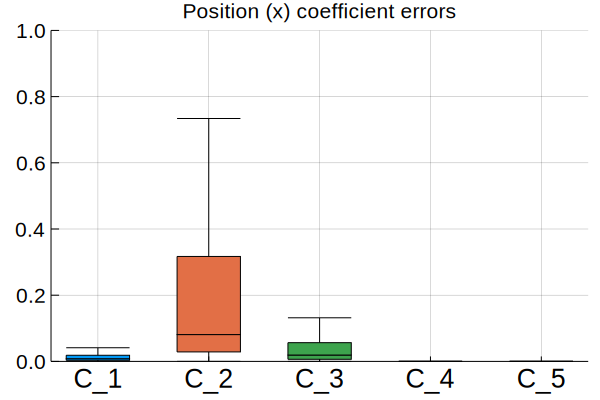

In [118]:
dim = 1
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (x) coefficient errors")

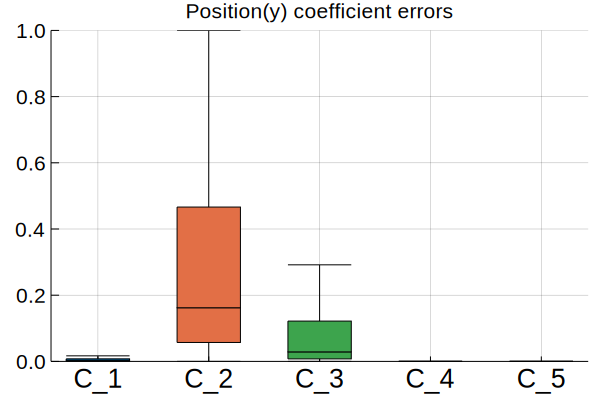

In [119]:
dim = 2
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(y) coefficient errors")


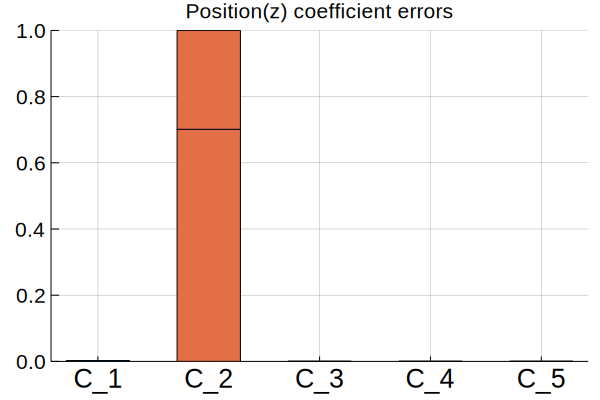

In [120]:
dim = 3
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(z) coefficient errors")

# Yeah this looks weird. Just change threshold to 4e-4 instead of 1e-4 and watch errors disappear.

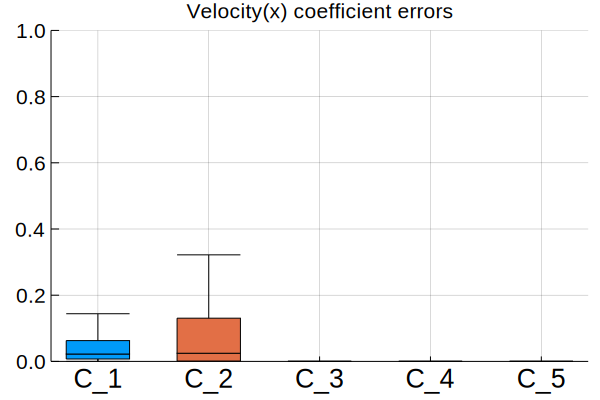

In [121]:
dim = 14
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(x) coefficient errors")


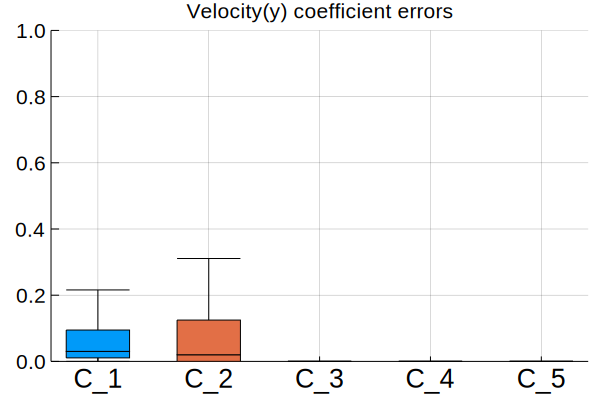

In [122]:
dim = 15
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(y) coefficient errors")


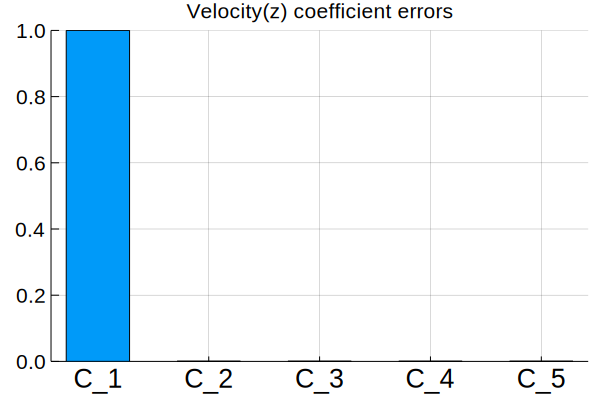

In [123]:
dim = 16
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(z) coefficient errors")


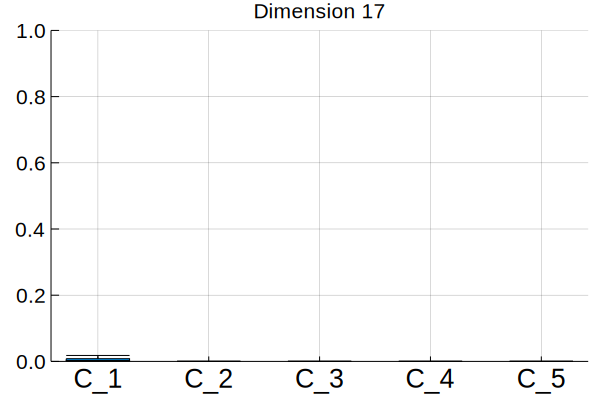

In [87]:
dim = 17
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Dimension $dim")

## Show random coeffs and trajectories to compare

In [35]:
N = 50
tf_guess = 110.
t_array = range(0,stop=tf_guess,length=N)

0.0:2.2448979591836733:110.0

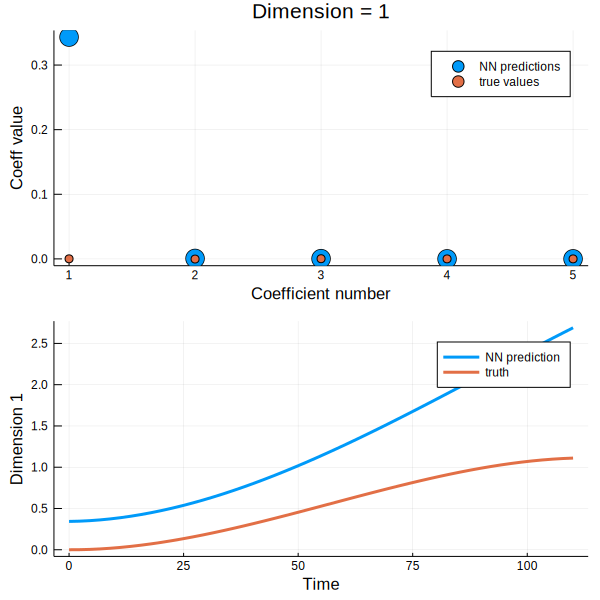

In [36]:
row = 1 # max = size(X_valid_norm,1) == 1130
dim = 1

xs = 1:1:5
NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs = true_coeffs_matrix[row,dim,:]
p1 = scatter(xs,NN_coeffs,grid=true, label="NN predictions",markersize = 10)
scatter!(xs,true_coeffs,grid=true,label="true values")
title!("Dimension = $dim")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)


NN_traj = recoverXUfromCoeffsSingleDim(NN_coeffs,dim)
true_traj = recoverXUfromCoeffsSingleDim(true_coeffs,dim)
p2 = plot(t_array,NN_traj,label="NN prediction",linewidth = 3)
plot!(t_array,true_traj, label = "truth",linewidth = 3)
xlabel!("Time")
ylabel!("Dimension $dim")
plot!(legend=:best)


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))

## Plot X and Y trajectories

x_init = [10.0, 2.22222]
x_final = [8.88889, 7.77778]
NN_coeffs_x = [9.91601, -1.3657e-8, -0.00034411, 1.66384e-6, 1.47345e-9]
true_coeffs_x = [9.99985, 0.000271587, -0.000264001, 1.54396e-6, -4.94547e-12]
NN_coeffs_y = [2.26421, -0.00187322, 0.00134741, -8.17292e-6, 1.18763e-9]
true_coeffs_y = [2.22321, -0.00148285, 0.00135483, -8.00002e-6, -1.90138e-10]


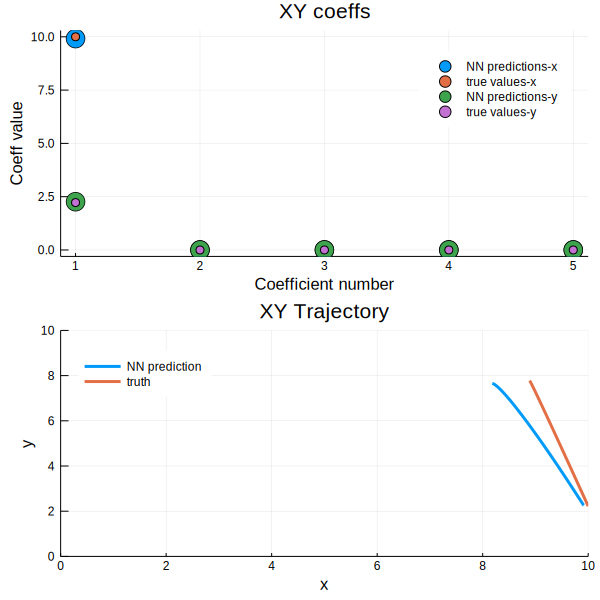

In [211]:
row = 230 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)

@show NN_coeffs_x
@show true_coeffs_x
@show NN_coeffs_y
@show true_coeffs_y

NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:topleft,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


x_init = [1.8125, 8.0]
x_final = [8.0, 5.0]


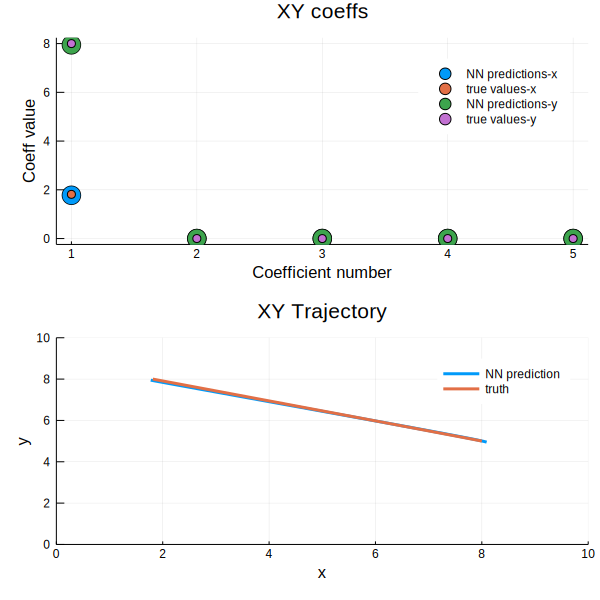

In [128]:
row = 200 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)


NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:best,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


## Compare x and vx coeffs

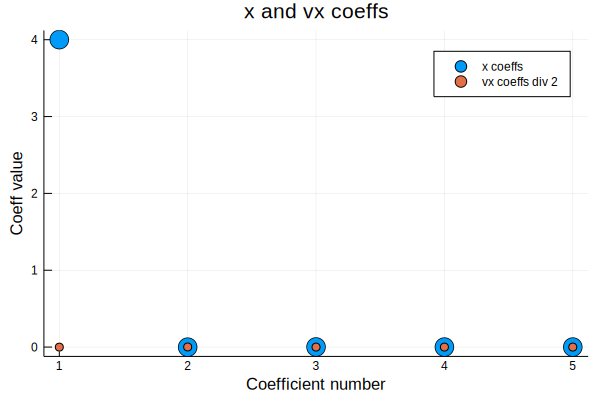

In [50]:
row = 17 # max = size(X_valid_norm,1) == 1130

xs = 1:1:5
# NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
true_coeffs_vx = true_coeffs_matrix[row,4,:]
p1 = scatter(xs,true_coeffs_x,grid=true, label="x coeffs",markersize = 10)
scatter!(xs,true_coeffs_vx./2.0,grid=true,label="vx coeffs div 2")
title!("x and vx coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)

## (Older) Manually compute mean and standard deviation

In [51]:
mean_smape = mean(smape, dims = 1)
std_smape = std(smape, dims = 1)
@show size(mean_smape)
@show size(std_smape)
num_dims = x_dim + u_dim
plots = Array{Plots.Plot{Plots.GRBackend}}(undef, num_dims, 1)
for dim in 1:num_dims
    xs = range(1,stop = 5, length = 5)
    μs = mean_smape[1,dim,:]
    σs = std_smape[1,dim,:]

    plots[dim] = scatter(xs,μs,grid=false,yerror=σs)
#     @show typeof(p1)
    title!("Dimension = $dim")
    xlabel!("Coefficient number")
    ylabel!("Relative error between NN and true value")
    plot!(legend=false)
end

size(mean_smape) = (1, 19, 5)
size(std_smape) = (1, 19, 5)


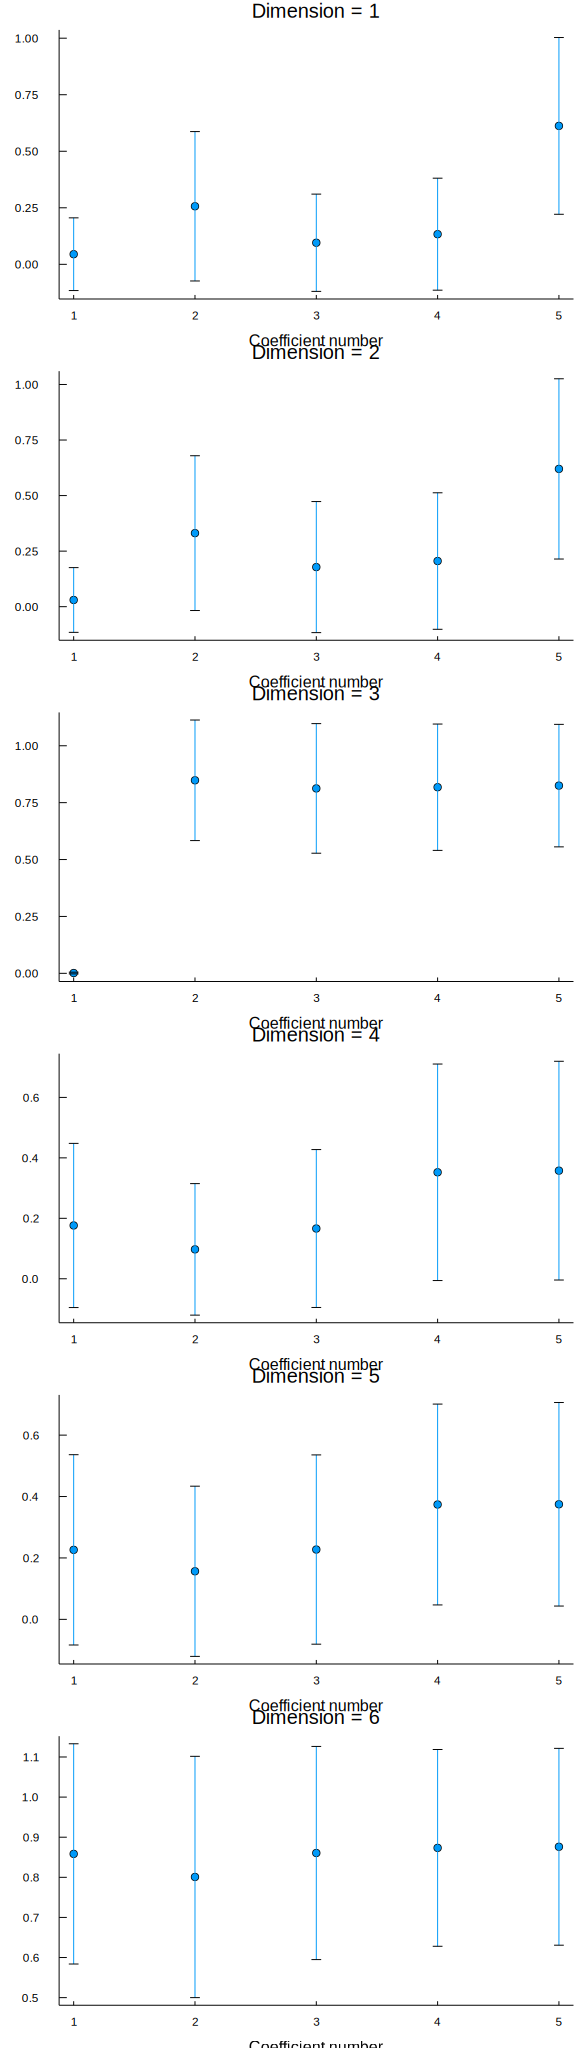

In [52]:
plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],
    layout=(6,1))
plot!(size=(600,6*350))

# Compare cold start and warm start GuSTO performance

### Collect the iteration number and times for each

In [28]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 1:2
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1
GuSTO solve time = 2.714230343 (6 iterations)
NN_solve_time = 0.001656792
GuSTO warm started solve time = 2.532885632 (5 iterations)

row = 2
GuSTO solve time = 3.526867846 (8 iterations)
NN_solve_time = 0.001814397
GuSTO warm started solve time = 5.808556339 (12 iterations)

row = 3
GuSTO solve time = 2.349790236 (5 iterations)
NN_solve_time = 0.001826795
GuSTO warm started solve time = 2.489891548 (5 iterations)

row = 4
GuSTO solve time = 2.60603577 (6 iterations)
NN_solve_time = 0.00174289
GuSTO warm started solve time = 2.249920814 (5 iterations)

row = 5
GuSTO solve time = 2.189115501 (5 iterations)
NN_solve_time = 0.001750169
GuSTO warm started solve time = 2.404912783 (5 iterations)

row = 6
GuSTO solve time = 2.417038132 (5 iterations)
NN_solve_time = 0.001893765
GuSTO warm started solve time = 2.567826798 (5 iterations)

row = 7
GuSTO solve time = 2.162796198 (5 iterations)
NN_solve_time = 0.001820388
GuSTO warm started solve time = 2.698600475 (5 iterations)

row = 8

GuSTO warm started solve time = 2.401300491 (5 iterations)

row = 114
GuSTO solve time = 26.003989594 (51 iterations)
NN_solve_time = 0.001758772
GuSTO warm started solve time = 11.12755476 (21 iterations)

row = 115
GuSTO solve time = 2.153073388 (5 iterations)
NN_solve_time = 0.001832214
GuSTO warm started solve time = 2.196577138 (5 iterations)

row = 116
GuSTO solve time = 13.434173827 (26 iterations)
NN_solve_time = 0.001867643
GuSTO warm started solve time = 5.287806212 (11 iterations)

row = 117
GuSTO solve time = 2.525194575 (5 iterations)
NN_solve_time = 0.002386845
GuSTO warm started solve time = 2.422108837 (5 iterations)

row = 118
GuSTO solve time = 2.300314985 (5 iterations)
NN_solve_time = 0.009134862
GuSTO warm started solve time = 2.402965715 (5 iterations)

row = 119
GuSTO solve time = 4.066994008 (9 iterations)
NN_solve_time = 0.001856667
GuSTO warm started solve time = 3.432905487 (7 iterations)

row = 120
GuSTO solve time = 5.69494748 (12 iterations)
NN_solve_time 

GuSTO warm started solve time = 5.808708117 (12 iterations)

row = 226
GuSTO solve time = 2.082187502 (5 iterations)
NN_solve_time = 0.001833265
GuSTO warm started solve time = 2.098539003 (5 iterations)

row = 227
GuSTO solve time = 1.977450431 (5 iterations)
NN_solve_time = 0.001825161
GuSTO warm started solve time = 2.480741764 (5 iterations)

row = 228
GuSTO solve time = 2.122257909 (5 iterations)
NN_solve_time = 0.001816205
GuSTO warm started solve time = 2.349119409 (5 iterations)

row = 229
GuSTO solve time = 4.294883432 (9 iterations)
NN_solve_time = 0.001793792
GuSTO warm started solve time = 8.23485856 (17 iterations)

row = 230
GuSTO solve time = 2.253543463 (5 iterations)
NN_solve_time = 0.001645739
GuSTO warm started solve time = 2.454437754 (5 iterations)

Intermediate save

row = 231
GuSTO solve time = 2.21146616 (5 iterations)
NN_solve_time = 0.001724284
GuSTO warm started solve time = 2.319425275 (5 iterations)

row = 232
GuSTO solve time = 2.349524374 (5 iterations)
N

GuSTO warm started solve time = 3.557415352 (7 iterations)

row = 338
GuSTO solve time = 2.520341432 (6 iterations)
NN_solve_time = 0.001775881
GuSTO warm started solve time = 2.420223543 (5 iterations)

row = 339
GuSTO solve time = 2.287019757 (5 iterations)
NN_solve_time = 0.001870523
GuSTO warm started solve time = 2.708116822 (5 iterations)

row = 340
GuSTO solve time = 2.28478635 (5 iterations)
NN_solve_time = 0.001725555
GuSTO warm started solve time = 2.409674462 (5 iterations)

Intermediate save

row = 341
GuSTO solve time = 2.466046396 (5 iterations)
NN_solve_time = 0.001800983
GuSTO warm started solve time = 2.498761674 (5 iterations)

row = 342
GuSTO solve time = 2.241050864 (5 iterations)
NN_solve_time = 0.001870924
GuSTO warm started solve time = 2.402587151 (5 iterations)

row = 343
GuSTO solve time = 3.864390552 (9 iterations)
NN_solve_time = 0.001852496
GuSTO warm started solve time = 4.267970948 (9 iterations)

row = 344
GuSTO solve time = 2.215525969 (5 iterations)
NN

GuSTO warm started solve time = 2.501050487 (5 iterations)

row = 450
GuSTO solve time = 2.251423663 (5 iterations)
NN_solve_time = 0.001898689
GuSTO warm started solve time = 2.550594271 (5 iterations)

Intermediate save

row = 451
GuSTO solve time = 7.68105935 (16 iterations)
NN_solve_time = 0.001895982
GuSTO warm started solve time = 3.812436869 (7 iterations)

row = 452
GuSTO solve time = 2.026763149 (5 iterations)
NN_solve_time = 0.001836573
GuSTO warm started solve time = 3.368143637 (7 iterations)

row = 453
GuSTO solve time = 2.189918467 (5 iterations)
NN_solve_time = 0.001842871
GuSTO warm started solve time = 2.580844245 (5 iterations)

row = 454
GuSTO solve time = 2.146882056 (5 iterations)
NN_solve_time = 0.001778392
GuSTO warm started solve time = 2.259146495 (5 iterations)

row = 455
GuSTO solve time = 2.190103417 (5 iterations)
NN_solve_time = 0.001850203
GuSTO warm started solve time = 2.293150135 (5 iterations)

row = 456
GuSTO solve time = 2.553052216 (5 iterations)
N

GuSTO warm started solve time = 7.565944903 (14 iterations)

row = 562
GuSTO solve time = 4.011140791 (9 iterations)
NN_solve_time = 0.001954048
GuSTO warm started solve time = 2.475670238 (5 iterations)

row = 563
GuSTO solve time = 2.745744743 (6 iterations)
NN_solve_time = 0.001931179
GuSTO warm started solve time = 4.391317344 (8 iterations)

row = 564
GuSTO solve time = 2.281541841 (5 iterations)
NN_solve_time = 0.00202622
GuSTO warm started solve time = 2.350754521 (5 iterations)

row = 565
GuSTO solve time = 2.649915004 (5 iterations)
NN_solve_time = 0.00190435
GuSTO warm started solve time = 2.518880258 (5 iterations)

row = 566
GuSTO solve time = 2.317111015 (5 iterations)
NN_solve_time = 0.001845458
GuSTO warm started solve time = 2.31787857 (5 iterations)

row = 567
GuSTO solve time = 2.194169424 (5 iterations)
NN_solve_time = 0.00174038
GuSTO warm started solve time = 2.477134461 (5 iterations)

row = 568
GuSTO solve time = 2.601421266 (5 iterations)
NN_solve_time = 0.00166

GuSTO warm started solve time = 2.394546332 (5 iterations)

row = 674
GuSTO solve time = 4.621995201 (10 iterations)
NN_solve_time = 0.001793693
GuSTO warm started solve time = 19.588378681 (43 iterations)

row = 675
GuSTO solve time = 2.459610168 (5 iterations)
NN_solve_time = 0.001830029
GuSTO warm started solve time = 2.723700686 (5 iterations)

row = 676
GuSTO solve time = 2.718637598 (6 iterations)
NN_solve_time = 0.001675869
GuSTO warm started solve time = 7.225146776 (14 iterations)

row = 677
GuSTO solve time = 3.523291621 (7 iterations)
NN_solve_time = 0.001653039
GuSTO warm started solve time = 6.349209959 (13 iterations)

row = 678
GuSTO solve time = 2.183951857 (5 iterations)
NN_solve_time = 0.001810859
GuSTO warm started solve time = 2.535258816 (5 iterations)

row = 679
GuSTO solve time = 4.112301239 (9 iterations)
NN_solve_time = 0.001769318
GuSTO warm started solve time = 3.047799663 (6 iterations)

row = 680
GuSTO solve time = 7.883145204 (16 iterations)
NN_solve_time 

GuSTO warm started solve time = 2.620650307 (5 iterations)

row = 786
GuSTO solve time = 2.247900333 (5 iterations)
NN_solve_time = 0.001951088
GuSTO warm started solve time = 2.420468559 (5 iterations)

row = 787
GuSTO solve time = 2.391290688 (5 iterations)
NN_solve_time = 0.001960882
GuSTO warm started solve time = 2.427421263 (5 iterations)

row = 788
GuSTO solve time = 2.402108018 (5 iterations)
NN_solve_time = 0.00189965
GuSTO warm started solve time = 2.599629785 (5 iterations)

row = 789
GuSTO solve time = 2.685669275 (6 iterations)
NN_solve_time = 0.00888315
GuSTO warm started solve time = 2.417002425 (5 iterations)

row = 790
GuSTO solve time = 2.150046098 (5 iterations)
NN_solve_time = 0.001846814
GuSTO warm started solve time = 2.519378119 (5 iterations)

Intermediate save

row = 791
GuSTO solve time = 2.476245734 (5 iterations)
NN_solve_time = 0.001879768
GuSTO warm started solve time = 2.443163764 (5 iterations)

row = 792
GuSTO solve time = 9.231260651 (18 iterations)
NN

GuSTO warm started solve time = 2.296387765 (5 iterations)

row = 842
GuSTO solve time = 2.22284533 (5 iterations)
NN_solve_time = 0.001807277
GuSTO warm started solve time = 2.310907963 (5 iterations)

row = 843
GuSTO solve time = 2.214119535 (5 iterations)
NN_solve_time = 0.00182957
GuSTO warm started solve time = 2.406000473 (5 iterations)

row = 844
GuSTO solve time = 2.138973091 (5 iterations)
NN_solve_time = 0.001796936
GuSTO warm started solve time = 2.520253456 (5 iterations)

row = 845
GuSTO solve time = 2.062144906 (5 iterations)
NN_solve_time = 0.001826067
GuSTO warm started solve time = 2.133842597 (5 iterations)

row = 846
GuSTO solve time = 2.412585044 (5 iterations)
NN_solve_time = 0.001812432
GuSTO warm started solve time = 2.560950315 (5 iterations)

row = 847
GuSTO solve time = 2.267419516 (5 iterations)
NN_solve_time = 0.001825008
GuSTO warm started solve time = 2.34983863 (5 iterations)

row = 848
GuSTO solve time = 2.291960684 (5 iterations)
NN_solve_time = 0.00184

GuSTO warm started solve time = 2.378052454 (5 iterations)

row = 954
GuSTO solve time = 2.476572176 (5 iterations)
NN_solve_time = 0.001640359
GuSTO warm started solve time = 2.557154151 (5 iterations)

row = 955
GuSTO solve time = 6.197643896 (13 iterations)
NN_solve_time = 0.001851433
GuSTO warm started solve time = 3.953055238 (8 iterations)

row = 956
GuSTO solve time = 2.118593113 (5 iterations)
NN_solve_time = 0.001830605
GuSTO warm started solve time = 2.374330708 (5 iterations)

row = 957
GuSTO solve time = 22.944757676 (45 iterations)
NN_solve_time = 0.001886686
GuSTO warm started solve time = 13.562818481 (25 iterations)

row = 958
GuSTO solve time = 7.494273201 (15 iterations)
NN_solve_time = 0.001833541
GuSTO warm started solve time = 10.96630337 (22 iterations)

row = 959
GuSTO solve time = 2.345416464 (5 iterations)
NN_solve_time = 0.001801922
GuSTO warm started solve time = 2.403742602 (5 iterations)

row = 960
GuSTO solve time = 3.842573151 (8 iterations)
NN_solve_time

GuSTO warm started solve time = 2.661921948 (5 iterations)

row = 1066
GuSTO solve time = 2.289971459 (5 iterations)
NN_solve_time = 0.001851648
GuSTO warm started solve time = 5.082048334 (10 iterations)

row = 1067
GuSTO solve time = 3.737497706 (8 iterations)
NN_solve_time = 0.001906927
GuSTO warm started solve time = 3.403628555 (7 iterations)

row = 1068
GuSTO solve time = 2.176078623 (5 iterations)
NN_solve_time = 0.001937599
GuSTO warm started solve time = 2.291313222 (5 iterations)

row = 1069
GuSTO solve time = 2.322204817 (5 iterations)
NN_solve_time = 0.001780588
GuSTO warm started solve time = 2.514696869 (5 iterations)

row = 1070
GuSTO solve time = 2.188477748 (5 iterations)
NN_solve_time = 0.001852733
GuSTO warm started solve time = 2.426383444 (5 iterations)

Intermediate save

row = 1071
GuSTO solve time = 2.684005258 (6 iterations)
NN_solve_time = 0.00190139
GuSTO warm started solve time = 4.079183057 (8 iterations)

row = 1072
GuSTO solve time = 2.220556403 (5 iterat

GuSTO warm started solve time = 2.399535338 (5 iterations)

row = 1122
GuSTO solve time = 2.304468323 (5 iterations)
NN_solve_time = 0.001816809
GuSTO warm started solve time = 3.018905101 (6 iterations)

row = 1123
GuSTO solve time = 2.317217608 (5 iterations)
NN_solve_time = 0.002069241
GuSTO warm started solve time = 2.538159896 (5 iterations)

row = 1124
GuSTO solve time = 2.31435733 (5 iterations)
NN_solve_time = 0.001993634
GuSTO warm started solve time = 6.232649001 (13 iterations)

row = 1125
GuSTO solve time = 2.300001984 (5 iterations)
NN_solve_time = 0.001852141
GuSTO warm started solve time = 2.530775791 (5 iterations)

row = 1126
GuSTO solve time = 2.413151003 (5 iterations)
NN_solve_time = 0.001892334
GuSTO warm started solve time = 4.278464441 (8 iterations)

row = 1127
GuSTO solve time = 2.090742698 (5 iterations)
NN_solve_time = 0.002144827
GuSTO warm started solve time = 4.234428201 (9 iterations)

row = 1128
GuSTO solve time = 3.80092553 (9 iterations)
NN_solve_time 

In [29]:
@show cold_start_data

cold_start_data = [1.0 6.0 2.71423; 1.0 8.0 3.52687; 1.0 5.0 2.34979; 1.0 6.0 2.60604; 1.0 5.0 2.18912; 1.0 5.0 2.41704; 1.0 5.0 2.1628; 1.0 5.0 2.28232; 1.0 42.0 21.3166; 1.0 5.0 2.28218; 1.0 5.0 2.63995; 1.0 12.0 6.39065; 1.0 5.0 2.3122; 1.0 11.0 5.06311; 1.0 8.0 3.73068; 1.0 5.0 2.22857; 1.0 5.0 2.37294; 1.0 6.0 2.72134; 1.0 5.0 2.14812; 1.0 6.0 2.72582; 1.0 5.0 2.4651; 1.0 51.0 27.0558; 1.0 5.0 2.1918; 1.0 8.0 3.61413; 1.0 5.0 2.33641; 1.0 5.0 2.32241; 1.0 9.0 4.31091; 1.0 5.0 2.27544; 1.0 5.0 2.16644; 1.0 26.0 12.5022; 1.0 5.0 2.4153; 1.0 5.0 2.28447; 1.0 8.0 3.51976; 1.0 5.0 2.21211; 1.0 5.0 2.22242; 1.0 5.0 2.2984; 1.0 8.0 3.93104; 1.0 17.0 8.0984; 1.0 5.0 2.3678; 1.0 5.0 2.2015; 1.0 15.0 8.29586; 1.0 5.0 2.41873; 1.0 8.0 3.83096; 1.0 5.0 2.04495; 1.0 5.0 2.26785; 1.0 5.0 2.20272; 1.0 6.0 2.68918; 1.0 7.0 3.02827; 1.0 5.0 2.22812; 1.0 5.0 2.20027; 1.0 5.0 2.20577; 1.0 5.0 2.34827; 1.0 7.0 3.02329; 1.0 5.0 2.04379; 1.0 5.0 2.21663; 1.0 16.0 7.5262; 1.0 5.0 2.39078; 1.0 5.0 2.0779

1130×3 Array{Float64,2}:
 1.0   6.0   2.71423
 1.0   8.0   3.52687
 1.0   5.0   2.34979
 1.0   6.0   2.60604
 1.0   5.0   2.18912
 1.0   5.0   2.41704
 1.0   5.0   2.1628 
 1.0   5.0   2.28232
 1.0  42.0  21.3166 
 1.0   5.0   2.28218
 1.0   5.0   2.63995
 1.0  12.0   6.39065
 1.0   5.0   2.3122 
 ⋮                  
 1.0   5.0   2.20794
 1.0   8.0   3.5867 
 1.0   5.0   2.19155
 1.0   5.0   2.30447
 1.0   5.0   2.31722
 1.0   5.0   2.31436
 1.0   5.0   2.3    
 1.0   5.0   2.41315
 1.0   5.0   2.09074
 1.0   9.0   3.80093
 1.0   5.0   2.27735
 1.0   5.0   2.23958

In [30]:
@show warm_start_data

warm_start_data = [1.0 5.0 2.53289; 1.0 12.0 5.80856; 1.0 5.0 2.48989; 1.0 5.0 2.24992; 1.0 5.0 2.40491; 1.0 5.0 2.56783; 1.0 5.0 2.6986; 1.0 5.0 2.31908; 1.0 8.0 3.99792; 1.0 6.0 3.01203; 1.0 5.0 2.62211; 1.0 14.0 7.65857; 1.0 5.0 2.50581; 0.0 200.0 97.8711; 1.0 14.0 7.02225; 1.0 6.0 2.9736; 1.0 5.0 2.58106; 1.0 7.0 3.65646; 1.0 5.0 2.35674; 1.0 11.0 5.45909; 1.0 5.0 2.67582; 1.0 8.0 4.05897; 1.0 5.0 2.38127; 1.0 13.0 6.70558; 1.0 5.0 2.43653; 1.0 5.0 2.46162; 1.0 9.0 4.67482; 1.0 5.0 2.43007; 1.0 5.0 2.34689; 1.0 10.0 5.07161; 1.0 5.0 2.33969; 1.0 5.0 2.64093; 1.0 7.0 3.44349; 1.0 5.0 2.35967; 1.0 5.0 2.27474; 1.0 5.0 2.60259; 1.0 7.0 3.58469; 1.0 20.0 10.9136; 1.0 6.0 3.33027; 1.0 5.0 2.61197; 1.0 23.0 11.4441; 1.0 5.0 2.54937; 1.0 7.0 3.63397; 1.0 5.0 2.37559; 0.0 200.0 91.2079; 1.0 5.0 2.39744; 1.0 5.0 2.40191; 1.0 5.0 2.50833; 1.0 5.0 2.45179; 1.0 6.0 3.13923; 1.0 5.0 2.23186; 1.0 5.0 2.58735; 1.0 8.0 3.79357; 1.0 5.0 2.20335; 1.0 5.0 2.40632; 1.0 14.0 6.47868; 1.0 5.0 2.3292; 1.

1130×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [31]:
@show NN_run_data

NN_run_data = [0.00165679; 0.0018144; 0.00182679; 0.00174289; 0.00175017; 0.00189376; 0.00182039; 0.00184479; 0.00160971; 0.00174628; 0.00189155; 0.00176492; 0.00170759; 0.00169011; 0.00185385; 0.00218924; 0.00175421; 0.00224732; 0.0019192; 0.00177926; 0.00165819; 0.00171589; 0.00178922; 0.0018674; 0.00176208; 0.00179761; 0.00170202; 0.00174804; 0.00174904; 0.00184821; 0.00177157; 0.00184495; 0.00802945; 0.0016721; 0.00180566; 0.00180804; 0.0018796; 0.0017064; 0.00183235; 0.00191777; 0.00164081; 0.00190039; 0.00184226; 0.00936382; 0.00188697; 0.00175689; 0.00839397; 0.00176236; 0.0017875; 0.00182665; 0.00181433; 0.00180186; 0.00188078; 0.00182742; 0.00187884; 0.0018955; 0.00180371; 0.00184309; 0.0019237; 0.0018401; 0.00187696; 0.00183809; 0.00185126; 0.00177919; 0.00181702; 0.00188502; 0.00186288; 0.00881063; 0.00183939; 0.0018173; 0.00180789; 0.00180112; 0.00179431; 0.00179558; 0.00186348; 0.00180531; 0.00184266; 0.00181578; 0.00178928; 0.00175748; 0.00180632; 0.00178967; 0.00178325; 

1130×1 Array{Float64,2}:
 0.001656792
 0.001814397
 0.001826795
 0.00174289 
 0.001750169
 0.001893765
 0.001820388
 0.001844792
 0.001609711
 0.001746277
 0.001891553
 0.001764918
 0.001707595
 ⋮          
 0.001897456
 0.001868587
 0.001780532
 0.001816809
 0.002069241
 0.001993634
 0.001852141
 0.001892334
 0.002144827
 0.001945072
 0.001906113
 0.001870961

## Plotting cold and warm start data

In [132]:
@load "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [140]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (1.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [144]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge


In [188]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1123×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [191]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 8.463045414069457
mean(cold_iter) = 9.219056099732859
mean(warm_time) = 4.232061255051647
mean(cold_time) = 4.434821645786287


4.434821645786287

mean(cold_iter) = 9.219056099732859
mean(warm_iter) = 8.463045414069457
median(cold_iter) = 5.0
median(warm_iter) = 5.0
size(diff_iter) = (1123, 2)


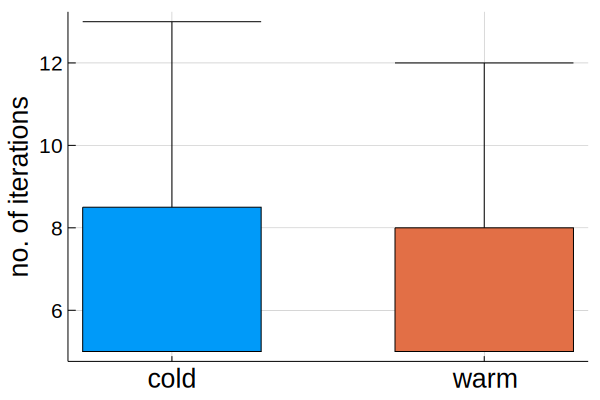

In [227]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


mean(diff_iter[:, 1]) = 4.434821645786287
mean(diff_iter[:, 2]) = 4.232061255051647
size(diff_iter) = (1123, 2)


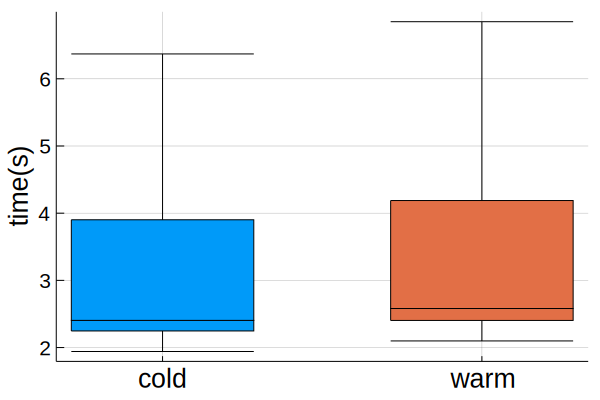

In [204]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [210]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

667

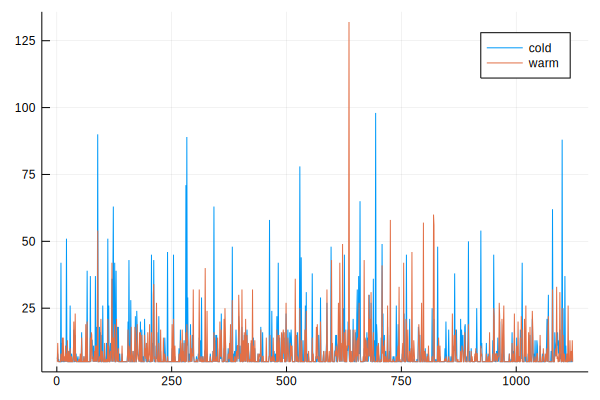

In [218]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


In [222]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (244, 3)
size(c_filt_large_iter) = (244, 3)


(244, 3)

mean(diff_iter[:, 1]) = 22.327868852459016
mean(diff_iter[:, 2]) = 14.540983606557377
median(diff_iter[:, 1]) = 16.0
median(diff_iter[:, 2]) = 12.0
size(diff_iter) = (244, 2)


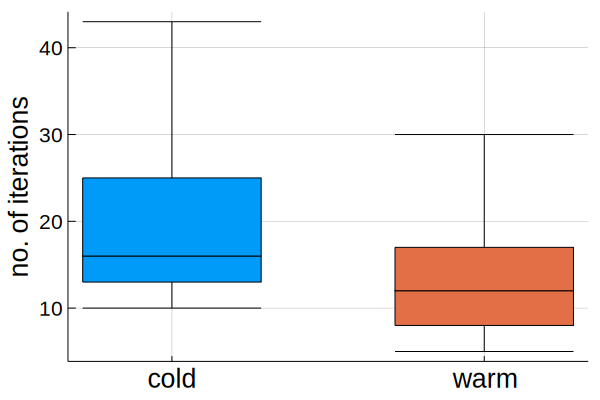

In [228]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [232]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (405, 3)
size(c_filt_large_iter) = (405, 3)


(405, 3)

mean(diff_iter[:, 1]) = 16.59259259259259
mean(diff_iter[:, 2]) = 13.57037037037037
median(diff_iter[:, 1]) = 12.0
median(diff_iter[:, 2]) = 10.0
size(diff_iter) = (405, 2)


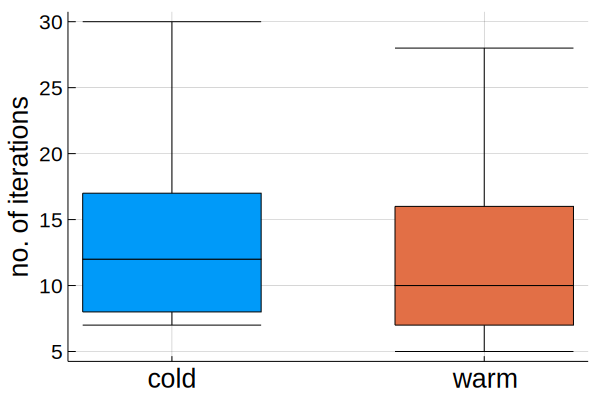

In [235]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


# Warm-starting
- Find GuSTO solution (time it, plot it)
- Find NN prediction (time it, plot it) 
- Start GuSTO with NN prediction (time it, plot it)

In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 7.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


## Refine plots

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
# xlabel!("x")
# ylabel!("y")
xaxis!(:off)
yaxis!(:off)
plot!(framestyle = :box)

In [ ]:
png("addABorder")

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], 2.5, 3, 0.002, 1.78, 1)
# plot!(legend = :best, legendfontsize = 9, fg_legend = :transparent)
# plot!(size = (500,500))
# plot!(aspect_ratio = 1.0)
plot!(legend = :best)


In [ ]:
png("testing")

In [ ]:
x_start= [0.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 5.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [7.0, 6.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Try new poly combo model

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("Simple case not bad 2")

In [ ]:
x_start= [0.5, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("2x good speedup")

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.5, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# Increase convergence threshold 
model.convergence_threshold = 5.0

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("5x speedup")

In [ ]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid obstacles 3")

# Try to add an obstacle to GuSTO now

In [ ]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([7.0,4.2,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

In [ ]:
plot_env_and_trajs(model, [X_all_init[end],X_all_new_cold[end],  X_all_new_warm[end]])

In [ ]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)


In [ ]:
png("warmstartexample")

# Get four differnt types of trajectories and compare the warm-starting

In [ ]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

# Plotting function

In [ ]:
function plot_three_comp_no_label(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 13)
    ylabel!("y", guidefontsize = 13)
    plot!(tickfontsize = 12)
    return fig
end

In [ ]:
function simplePlot(x_start, x_goal)
    x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
    x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


    # GuSTO solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
    gusto_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    paramsFileName = "PolyComboParams.h5"
    jsonFileName = "SimpleAstrobeeTemplate.json"
    weightsFileName = "PolyComboWeights.h5"
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

    p = plot_three_comp_no_label(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
    return p
end

# Four plots in one

In [ ]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
p1=simplePlot(x_start, x_goal)
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
p2=simplePlot(x_start, x_goal)
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
p3=simplePlot(x_start, x_goal)
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
p4=simplePlot(x_start, x_goal)
plot()
plot!(p1,p2,p3,p4)

In [ ]:
plot()
plot!(p2)
plot!(p1,p2)
# plot!(p1,p2,p3,p4,layout=(2,2))

In [ ]:
plot(p1,p2,p3,p4,layout=(2,2), size=(800,800))

In [ ]:
png("AllFour")

# Rejected for now

In [ ]:
x_start= [2.0, 6.0, 0.5]
x_goal = [9.0, 2., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [2.222, 10.0, 0.5]
x_goal = [6.6667, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.25, 5.8125, 0.5]
x_goal = [9.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles 2")

In [ ]:
x_start= [3.125, 7.6875, 0.5]
x_goal = [9.5, 3.875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :bottomright)

In [ ]:
png("Simple case not bad")

In [ ]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("Almost perfect 1.5x")

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
png("3DForAlmostPerfectCase")

# Try to add an obstacle to GuSTO now

In [ ]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([6.0,4.0,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

In [ ]:
labls = ["Straight line initialization", "GuSTO did not converge ($numIter iterations, $gusto_solve_time seconds)", "NN initialization", "GuSTO warm-started ($numIter_warm iterations, $gusto_warm_solve_time seconds)"]
X_straight = hcat(range(x_init, stop=x_final, length=50)...)
plot_custom(model, [X_straight, X_all_new_cold[end], X_soln_NN,   X_all_new_warm[end]], labls)
plot!(size=(600,600),legend=:best,legendfontsize = 10)
xlabel!("x")
ylabel!("y")

In [ ]:
png("gustoadaptswithwarm")

In [ ]:
function plot_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
        idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1                 
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 1)
        elseif iter == 2
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter ==3
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 3)
        elseif iter ==4
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 3)
#             @show r.color
#         else
#             plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
#     annotate!([(st_pt[1]-0.2, st_pt[2]+0.4, text("Start", 12, :black, :left)), 
#             (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 12, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

In [ ]:
x_start= [1.375, 8., 0.5]
x_goal = [5.5, 4.4375, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [0.9375, 8., 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [9.0, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles")

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [8.0, 1.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN speedup and switches homotopy class")

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [8.0, 7.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
function plot_three_comp_3D_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["", "", ""]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

In [ ]:
plot_three_comp_3D_custom(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, legend = :top)

In [ ]:
png("3DVizTraj")

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [2.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:bottomright)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [9.0, 3.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [5.0, 7.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [6.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the X trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the x trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 9.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 10.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Not implemented yet

In [ ]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    model = getModelWithCornerSpheres()
    

    
#     gusto_setup_time = (time_ns() - time_start)/10^9

#     times = []
    
#     time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end